# 2. Data preparation

---

### Setup

In [1]:
import sys
sys.path.insert(1, '../../utils')

import pandas as pd

original: pd.DataFrame = pd.read_csv('../heart_failure_clinical_records_dataset_after_profiling.csv', sep=';')

cols_nr = original.select_dtypes(include='number')
cols_sb = original.select_dtypes(include='bool')

original.describe()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
count,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000
mean,60.833893,581.839465,38.083612,263358.029264,1.39388,136.625418,130.260870
std,11.894809,970.287881,11.834841,97804.236869,1.03451,4.412477,77.614208
min,40.000000,23.000000,14.000000,25100.000000,0.50000,113.000000,4.000000
25%,51.000000,116.500000,30.000000,212500.000000,0.90000,134.000000,73.000000
50%,60.000000,250.000000,38.000000,262000.000000,1.10000,137.000000,115.000000
75%,70.000000,582.000000,45.000000,303500.000000,1.40000,140.000000,203.000000
max,95.000000,7861.000000,80.000000,850000.000000,9.40000,148.000000,285.000000


## 2.0. Data preparation

---

### Missing Values Imputation

---

In our dataset there are no missing values and therefore this step is not appliable.

In [2]:
df_nr = cols_nr
df_sb = cols_sb

### Outliers Imputation

---

In [3]:
# TODO

### Scaling

---

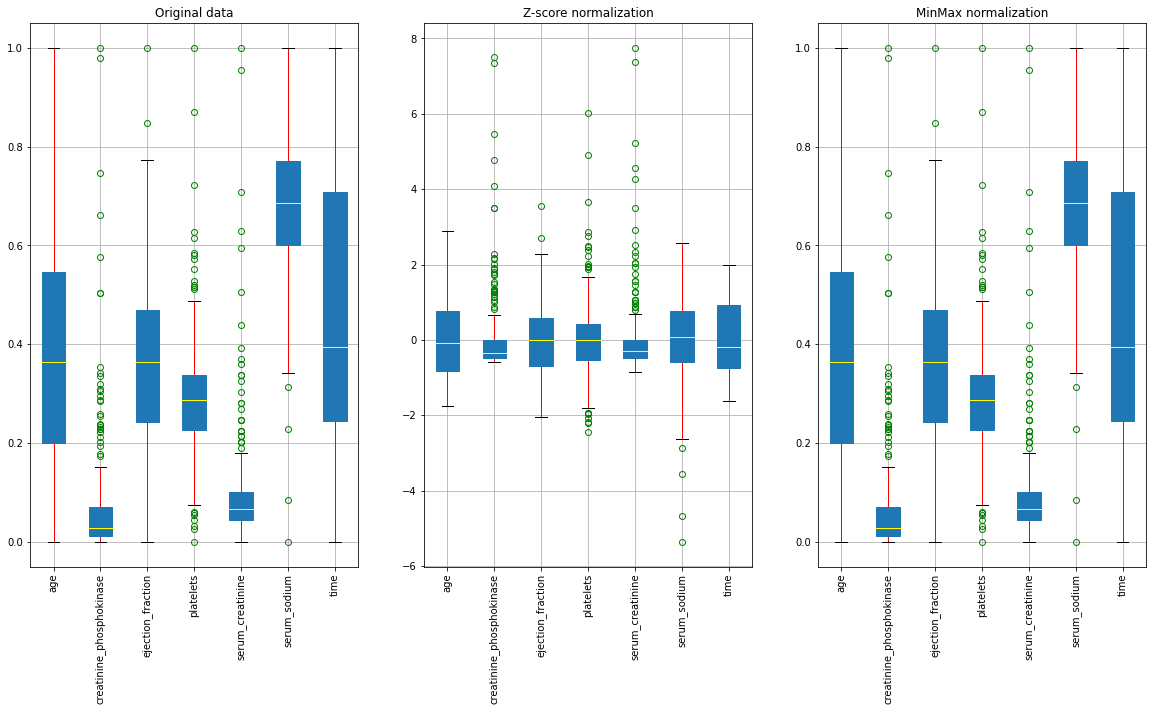

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

transf = StandardScaler(with_mean=True, with_std=True, copy=True).fit(df_nr)
df_nr = pd.DataFrame(transf.transform(df_nr), columns= df_nr.columns)
norm_data_zscore = df_nr

transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
df_nr = pd.DataFrame(transf.transform(df_nr), columns= df_nr.columns)
norm_data_minmax = df_nr

import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows = 1, ncols=3, figsize=(20, 10),squeeze=False)
axs[0, 0].set_title('Original data')
df_nr.boxplot(ax=axs[0, 0], rot=90, patch_artist=True, whiskerprops=dict(color='red'), medianprops=dict(color='yellow'), flierprops=dict(color='green', markeredgecolor='green'))
axs[0, 1].set_title('Z-score normalization')
norm_data_zscore.boxplot(ax=axs[0, 1], rot=90, patch_artist=True, whiskerprops=dict(color='red'), medianprops=dict(color='yellow'), flierprops=dict(color='green', markeredgecolor='green'))
axs[0, 2].set_title('MinMax normalization')
norm_data_minmax.boxplot(ax=axs[0, 2], rot=90, patch_artist=True, whiskerprops=dict(color='red'), medianprops=dict(color='yellow'), flierprops=dict(color='green', markeredgecolor='green'))
plt.show()

In [5]:
# Rejoin numeric with symbolic variables
norm_data_zscore = norm_data_zscore.join(df_sb, how='right')
norm_data_minmax = norm_data_minmax.join(df_sb, how='right')

### Splits

---

In [6]:
import numpy as np

ndm_copy = norm_data_minmax.copy(deep = True)

target = 'DEATH_EVENT'
positive = True
negative = False
values = {'Original': [len(ndm_copy[ndm_copy[target] == positive]), 
                       len(ndm_copy[ndm_copy[target] == negative])]}

y: np.ndarray = ndm_copy.pop(target).values
X: np.ndarray = ndm_copy.values
labels: np.ndarray = pd.unique(y)

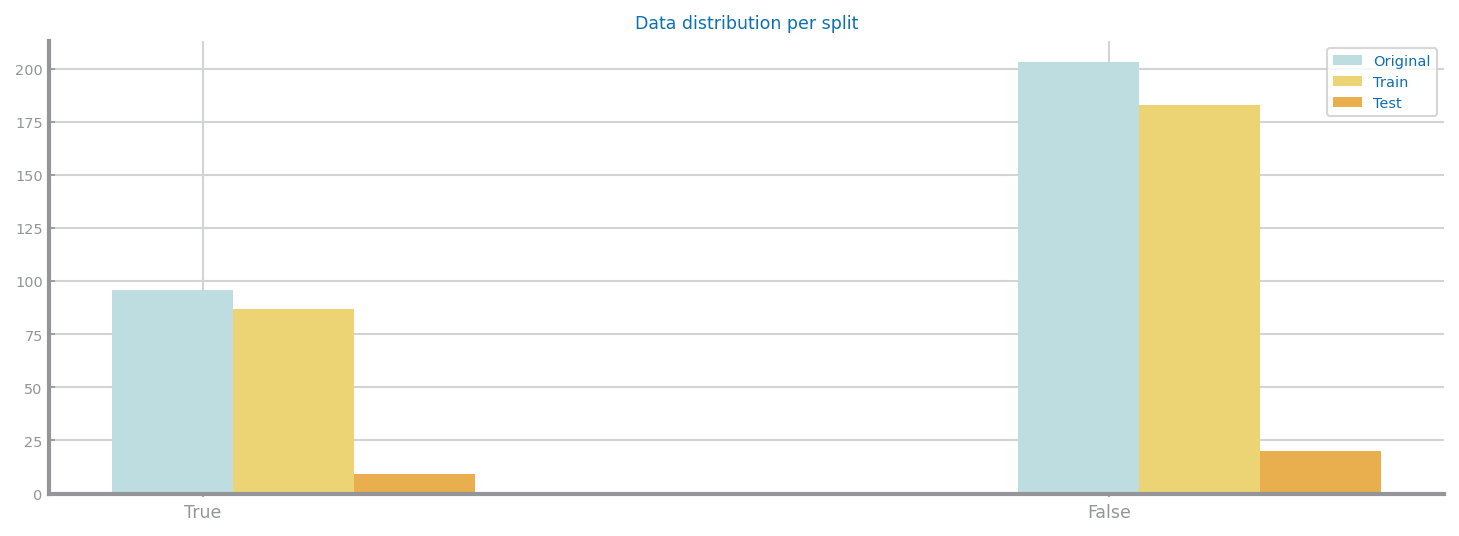

In [7]:
from sklearn.model_selection import StratifiedKFold
import ds_functions as ds

np.random.seed(1)
skf = StratifiedKFold(n_splits=10, shuffle=True)
skf.get_n_splits(X, y)

splits=[]

for train_index, test_index in skf.split(X, y):
    splits.append({'X_train': X[train_index], 'X_test': X[test_index],
                  'y_train': y[train_index], 'y_test': y[test_index]})

values['Train'] = [len(np.delete(y[train_index], np.argwhere(y[train_index]==negative))), len(np.delete(y[train_index], np.argwhere(y[train_index]==positive)))]
values['Test'] = [len(np.delete(y[test_index], np.argwhere(y[test_index]==negative))), len(np.delete(y[test_index], np.argwhere(y[test_index]==positive)))]

plt.figure(figsize=(12,4))
ds.multiple_bar_chart([positive, negative], values, title='Data distribution per split', showXTickLabels=True)
plt.show()

### Data balancing

---

In [8]:
# Convert splits to dataframes
columnsX = list(norm_data_minmax.columns)
columnsX.remove(target)

for split in splits:
    split['X_train'] = pd.DataFrame(data=split['X_train'], columns=columnsX)
    split['y_train'] = pd.DataFrame(data=split['y_train'], columns=[target])
    split['X_test'] = pd.DataFrame(data=split['X_test'], columns=columnsX)
    split['y_test'] = pd.DataFrame(data=split['y_test'], columns=[target])

firstData = pd.concat([splits[0]['X_train'], splits[0]['y_train']], axis = 1)

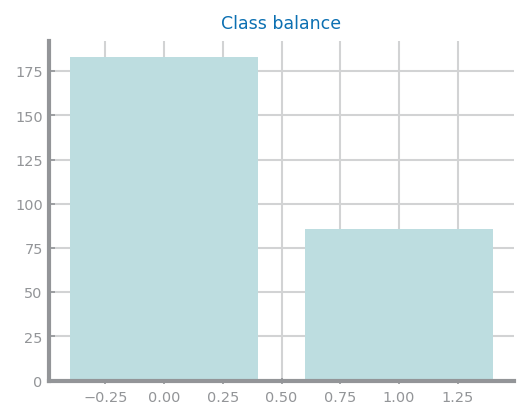

Minority class: 86
Majority class: 183
Proportion: 0.47 : 1


In [9]:
import matplotlib.pyplot as plt

target_count = firstData['DEATH_EVENT'].value_counts()
plt.figure()
plt.title('Class balance')
plt.bar(target_count.index, target_count.values)
plt.show()

min_class = target_count.idxmin()
ind_min_class = target_count.index.get_loc(min_class)

print('Minority class:', target_count[ind_min_class])
print('Majority class:', target_count[1-ind_min_class])
print('Proportion:', round(target_count[ind_min_class] / target_count[1-ind_min_class], 3), ': 1')

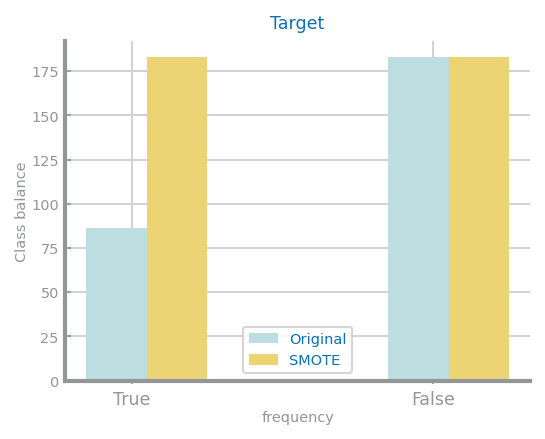

In [10]:
import ds_functions as ds
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42
values = {'Original': [target_count.values[ind_min_class], target_count.values[1-ind_min_class]]}

smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)

smote_X = [None] * len(splits)
smote_y = [None] * len(splits)

for spli in range(len(splits)):
    split = splits[spli]
    y = split['y_train'].values
    X = split['X_train'].values
    smote_X[spli], smote_y[spli] = smote.fit_sample(X, y)

smote_target_count = pd.Series(smote_y[0]).value_counts()
values['SMOTE'] = [smote_target_count.values[ind_min_class], smote_target_count.values[1-ind_min_class]]

fig = plt.figure()
ds.multiple_bar_chart([target_count.index[ind_min_class], target_count.index[1-ind_min_class]], values,
                      title='Target', xlabel='frequency', ylabel='Class balance', showXTickLabels=True)
plt.show()

In [50]:
smote_data = [None] * len(splits)
train_data = [None] * len(splits)
test_data = [None] * len(splits)

for spli in range(len(splits)):
    split = splits[spli]
    smote_data[spli] = pd.DataFrame(np.concatenate([smote_X[spli], smote_y[spli][:,None]], axis=1), columns=norm_data_minmax.columns)
    
    train_data[spli] = pd.concat((split['X_train'], split['y_train']), axis = 1)
    test_data[spli] = pd.concat((split['X_test'], split['y_test']), axis = 1)
    
    
    # Finally, export prepared data to csv
    train_data[spli].to_csv('data/prepared/%d.csv' % spli, sep=';', index=False)
    smote_data[spli].to_csv('data/prepared_b/%d.csv' % spli, sep=';', index=False)
    test_data[spli].to_csv('data/prepared_test/%d.csv' % spli, sep=';', index=False)

### Feature Generation

---

In [12]:
old_data = {'train': train_data, 'test': test_data}
gen_data = {'train': [None] * len(splits), 'test': [None] * len(splits)}

for d in old_data:
    old_splits = old_data[d]
    for spli in range(len(old_splits)):
        df_gen = old_splits[spli]
        df_gen = df_gen.astype({
            'age': 'float64',
            'creatinine_phosphokinase': 'float64',
            'ejection_fraction': 'float64',
            'platelets': 'float64',
            'serum_creatinine': 'float64',
            'serum_sodium': 'float64',
            'time': 'float64'})
        df_gen_nr = df_gen.select_dtypes(include='number')
        op_names = ('sum', 'diff', 'prod')
        ops = (lambda x,y: x+y, lambda x,y: x-y, lambda x,y: x*y)

        new_df_gen_nr = pd.DataFrame()

        index = 0
        for o in range(len(ops)):
            for col1 in df_gen_nr.columns:
                for col2 in df_gen_nr.columns:
                    if col1 == col2:
                        break
                    new_col = ops[o](df_gen_nr[col1], df_gen_nr[col2])
                    name = op_names[o] + '(' + col1 + ',' + col2 + ')'
                    new_df_gen_nr.insert(index, name, new_col)
                    index += 1

        gen_data[d][spli] = new_df_gen_nr.join(df_gen, how='right')

In [13]:
for spli in range(len(gen_data['test'])):
    gen_data['test'][spli].to_csv('data/prepared_g_test/%d.csv' % spli, sep=';', index=False)

In [14]:
print(gen_data['train'])

[     sum(creatinine_phosphokinase,age)  sum(ejection_fraction,age)  \
0                             0.707683                    0.727273   
1                             1.272727                    0.636364   
2                             0.470238                    0.545455   
3                             0.193046                    0.272727   
4                             0.472024                    0.545455   
..                                 ...                         ...   
264                           0.401529                    0.681818   
265                           0.428389                    0.736364   
266                           0.404848                    0.763636   
267                           0.350797                    0.787879   
268                           0.395834                    0.454545   

     sum(ejection_fraction,creatinine_phosphokinase)  sum(platelets,age)  \
0                                           0.162228            0.927187   
1     

### Feature Selection

---

#### Unsupervised Selection

By definition, unsupervised selection only aims for eliminating redundancies among the
variables, getting the smallest set possible.

In [15]:
import seaborn as sns
import numpy as np

y_list = [{'smote': None, 'train': None} for _ in range(len(splits))]
X_list = [{'smote': None, 'train': None} for _ in range(len(splits))]

for spli in range(len(splits)):
    data_dict = {'smote': smote_data[spli], 'train': gen_data['train'][spli]}
    for key in data_dict:
        df = data_dict[key]
        
        copy = df.copy(deep=True)
        copy = copy.drop('DEATH_EVENT', axis = 1)
        corr_mtx_copy = copy.corr()

        removed = []

        for x in corr_mtx_copy:
            for y in corr_mtx_copy:
                if x == y:
                    break
                corr = corr_mtx_copy[x][y]
                if abs(corr) >= 0.8 and x not in removed and y not in removed:
                    copy = copy.drop(x, axis=1)
                    removed.append(x)
                    break

        copy['DEATH_EVENT'] = df['DEATH_EVENT']
        if key == 'smote':
            smote_data[spli] = copy.copy()
        else:
            gen_data['train'][spli] = copy.copy()
        y_list[spli][key] = copy['DEATH_EVENT'].values
        X_list[spli][key] = copy.drop('DEATH_EVENT', axis=1).values

In [24]:
#smote_data[0].drop('anaemia', axis=1)

#### Supervised Selection


In the context of supervised selection, the goal is to identify the most relevant variables
in relation to the target variable, and so we need criteria able to relate each variable
with the target one.
We will use sequential backward selection to select our sets of variables.

In [27]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier

bestSets = [{'smote': None, 'train': None} for _ in range(len(splits))]

for spli in range(len(splits)):
    column_names = {
        'smote': smote_data[spli].drop('DEATH_EVENT', axis=1).columns,
        'train': gen_data['train'][spli].drop('DEATH_EVENT', axis=1).columns
    }
    print('Split %d' % spli)
    for key in ('smote', 'train'):
        y = y_list[spli][key]
        X = X_list[spli][key]
        
        bestAvgScore = 0
        bestSets[spli][key] = None
        bestNeighbors = -1

        for n_neighbors in range(1, 13):
            knn = KNeighborsClassifier(n_neighbors=n_neighbors)

            sbfs = SFS(knn,
                       k_features=12,
                       forward=True,
                       floating=False,
                       scoring='accuracy',
                       cv=10,
                       n_jobs=-1)

            sbfs = sbfs.fit(X, y, custom_feature_names=column_names[key])
            
            for subset in sbfs.subsets_:
                if (sbfs.subsets_[subset]['avg_score'] > bestAvgScore):
                    bestAvgScore = sbfs.subsets_[subset]['avg_score']
                    bestSets[spli][key] = sbfs.subsets_[subset]['feature_names']
                    bestNeighbors = n_neighbors
        
        print(key.upper() + ':')
        print('Best Set:', bestSets[spli][key])
        print('Accuracy:', bestAvgScore)
        print('Nº neighbors:', bestNeighbors)
        print('---')

Split 0
SMOTE:
Best Set: ('age', 'creatinine_phosphokinase', 'ejection_fraction', 'serum_creatinine', 'time', 'smoking')
Accuracy: 0.8777777777777779
Nº neighbors: 1
---
TRAIN:
Best Set: ('sum(ejection_fraction,age)', 'sum(time,ejection_fraction)', 'prod(time,creatinine_phosphokinase)', 'platelets', 'sex')
Accuracy: 0.8655270655270655
Nº neighbors: 7
---
Split 1
SMOTE:
Best Set: ('ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time', 'anaemia')
Accuracy: 0.867042042042042
Nº neighbors: 3
---
TRAIN:
Best Set: ('sum(serum_creatinine,platelets)', 'sum(time,ejection_fraction)', 'diff(time,creatinine_phosphokinase)', 'prod(creatinine_phosphokinase,age)', 'prod(time,platelets)', 'sex', 'smoking')
Accuracy: 0.8544159544159544
Nº neighbors: 10
---
Split 2
SMOTE:
Best Set: ('age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time', 'high_blood_pressure', 'sex')
Accuracy: 0.8834834834834835
Nº neighbors: 1
---
TRAIN:
Be

In [28]:
for spli in range(len(splits)):
    for key in ('smote', 'train'):
        final_data = smote_data[spli] if key == 'smote' else gen_data['train'][spli]
        
        for feature in final_data.columns:
            if feature not in bestSets[spli][key] and feature != 'DEATH_EVENT':
                final_data = final_data.drop(feature, axis=1)
                
        folder = 'b_s' if key == 'smote' else 'mm_gs'
        final_data.to_csv('data/prepared_%s/%d.csv' % (folder, spli), sep=';', index=False)

### Feature Extraction

---

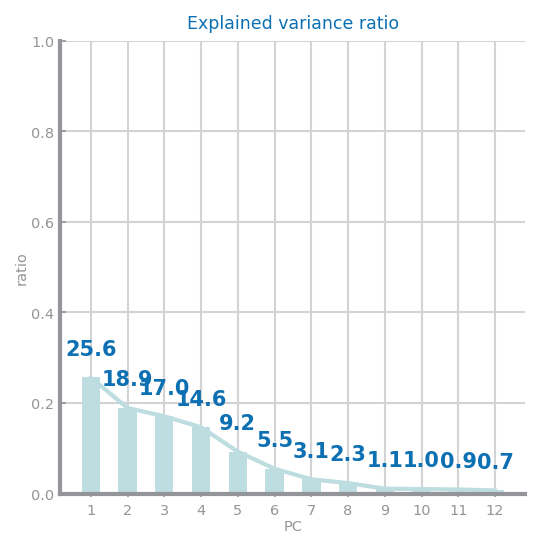

          PC1       PC2       PC3       PC4       PC5       PC6
0   -0.465701  0.352032  0.771370  0.659026 -0.815530 -0.003191
1   -0.642750  0.003899 -0.090168  0.256225 -0.674659  0.027062
2   -1.231851  0.020860 -0.024788  0.682216  0.001921  0.070410
3   -0.420341  0.793313 -0.562187  0.665306 -0.625931 -0.129961
4    0.618210  0.240933 -0.641083  1.068653  0.003177  0.096609
..        ...       ...       ...       ...       ...       ...
264 -0.634570 -0.074904 -0.169655  0.204221 -0.673853 -0.776738
265 -0.613733  0.093494 -0.769407  1.652152  0.030444 -0.880619
266 -0.651595 -0.375841  0.551507  1.632982 -0.124073 -0.955969
267  0.429012 -0.686621 -0.259435  0.571776  0.055049 -0.857245
268 -1.233238 -0.149534 -0.126555  0.565726  0.042236 -0.953582

[269 rows x 6 columns]


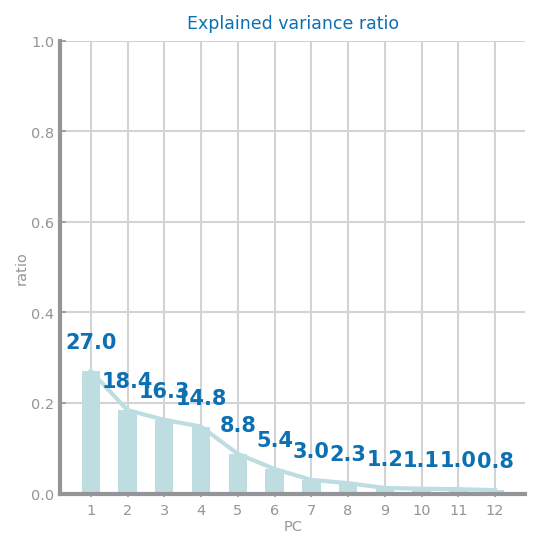

          PC1       PC2       PC3       PC4       PC5       PC6
0   -0.413214  0.466872  0.989497  0.214834 -0.776293 -0.100585
1   -0.621064  0.085601  0.068425  0.314545 -0.689590 -0.071638
2   -1.213590  0.217120  0.306676  0.630435  0.019351  0.058854
3   -0.316257  0.896790 -0.202433  0.802666 -0.579348 -0.228700
4    0.662115  0.308808 -0.055791  1.212926  0.064167  0.081085
..        ...       ...       ...       ...       ...       ...
264 -0.659187 -0.127742  1.297451  1.213789  0.069019 -0.974572
265 -0.018146 -0.123552 -0.102988 -0.045282  0.139325 -0.814817
266  0.368688 -0.664119  0.103236  0.697041  0.179372 -0.866832
267 -1.232748  0.026658  0.180244  0.585098  0.166349 -0.961909
268 -1.221556  0.040017  0.189830  0.591191  0.187336 -0.940287

[269 rows x 6 columns]


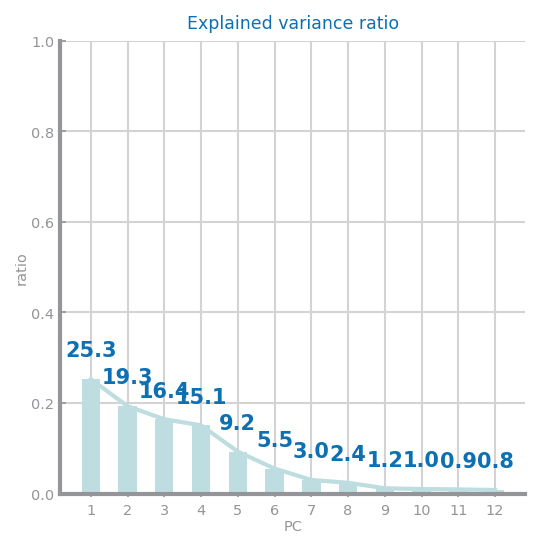

          PC1       PC2       PC3       PC4       PC5       PC6
0   -0.436769  0.393046  0.990430  0.315545 -0.794255 -0.073265
1   -0.638589  0.037854  0.066671  0.274964 -0.687977 -0.045834
2   -1.235162  0.123103  0.268673  0.624269  0.026992  0.015704
3   -0.381883  0.806369 -0.253834  0.829520 -0.632759 -0.193394
4    0.617304  0.202941 -0.174919  1.247979  0.022513  0.037370
..        ...       ...       ...       ...       ...       ...
264 -0.624378  0.161222 -0.043724  1.785392  0.098903 -0.980386
265 -0.674656 -0.282415  1.178100  1.252573 -0.036844 -1.053578
266 -0.000452 -0.090817 -0.094639 -0.099995  0.059252 -0.848333
267  0.380298 -0.699126  0.016231  0.610221  0.109155 -0.943630
268 -1.224236 -0.029148  0.143312  0.532068  0.117060 -1.008215

[269 rows x 6 columns]


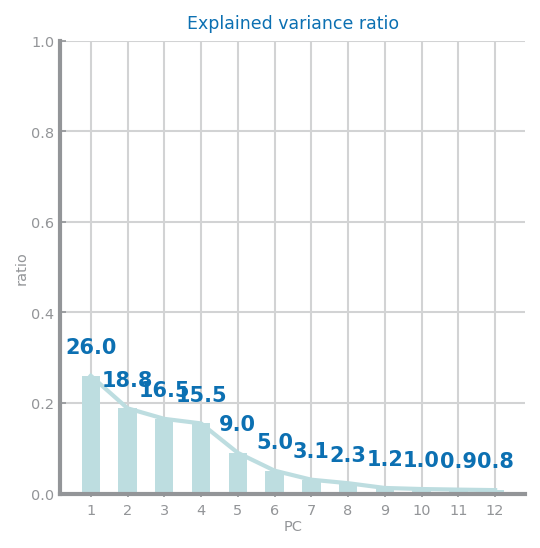

          PC1       PC2       PC3       PC4       PC5       PC6
0   -0.416884  0.523753  0.594633  0.834272 -0.737542 -0.002499
1   -1.242408  0.168565 -0.131652  0.629537  0.054505  0.067801
2   -0.385372  0.696617 -0.780016  0.530250 -0.661182 -0.126148
3    0.584235  0.083493 -0.897915  0.904949  0.040493  0.069741
4   -0.750332  1.284434 -0.118085  1.336123 -0.005726 -0.073114
..        ...       ...       ...       ...       ...       ...
264 -0.676981  0.055049 -1.084630  1.384320  0.095335 -0.886559
265 -0.011799 -0.127838 -0.025135 -0.158389  0.002819 -0.762862
266  0.335595 -0.755958 -0.252007  0.525044  0.098368 -0.836191
267 -1.257654 -0.031037 -0.175064  0.466379  0.065335 -0.935421
268 -1.245773 -0.021750 -0.175795  0.469808  0.085322 -0.915922

[269 rows x 6 columns]


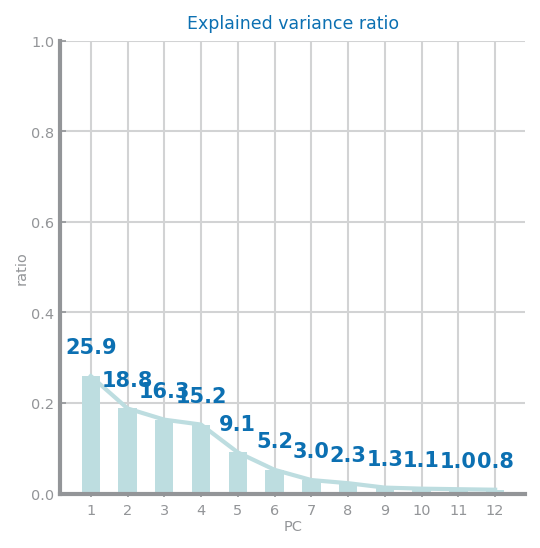

          PC1       PC2       PC3       PC4       PC5       PC6
0   -0.655458  0.050464 -0.047455  0.267674 -0.655878  0.020426
1   -0.393912  0.757701 -0.677768  0.608366 -0.627827 -0.131661
2    0.638686  0.203684 -0.621026  1.064358  0.011283  0.043214
3   -0.829349  1.346419  0.140914  1.242960  0.065600 -0.088879
4   -0.406914  0.795599 -0.667815  0.605651 -0.628434 -0.016557
..        ...       ...       ...       ...       ...       ...
264 -0.721619 -0.021813  0.645176  1.626109  0.013746 -1.000728
265 -0.027233 -0.111687 -0.047350 -0.102053  0.080329 -0.861987
266  0.385210 -0.651811 -0.070409  0.651315  0.077471 -0.939271
267 -1.262875 -0.051085 -0.118722  0.573454  0.105229 -0.955302
268 -1.247703 -0.041274 -0.117489  0.576979  0.133512 -0.960467

[269 rows x 6 columns]


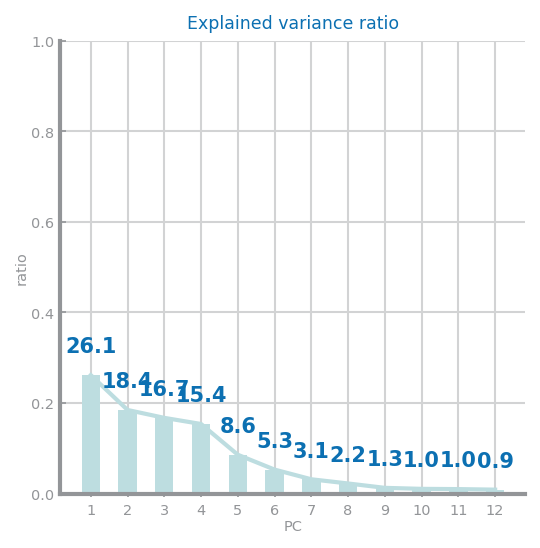

          PC1       PC2       PC3       PC4       PC5       PC6
0   -0.522374  0.614922  0.380576  0.826121 -0.754555 -0.082089
1   -0.662932  0.012524 -0.172730  0.240649 -0.663753 -0.057257
2   -1.251847  0.079914 -0.294528  0.590067  0.067017 -0.006697
3    0.626785 -0.020538 -0.925403  0.855224  0.015300  0.023691
4   -0.826549  1.215626 -0.464759  1.298088  0.027804 -0.187688
..        ...       ...       ...       ...       ...       ...
264 -0.747173 -0.139414  0.154303  1.709327  0.021051 -1.050737
265  0.000641 -0.132553  0.033897 -0.129587  0.046098 -0.865841
266  0.379751 -0.772673 -0.109750  0.555032  0.084982 -0.916509
267 -1.238784 -0.121402 -0.255499  0.454967  0.123387 -1.037661
268 -1.227065 -0.115515 -0.256325  0.463067  0.144649 -1.022787

[269 rows x 6 columns]


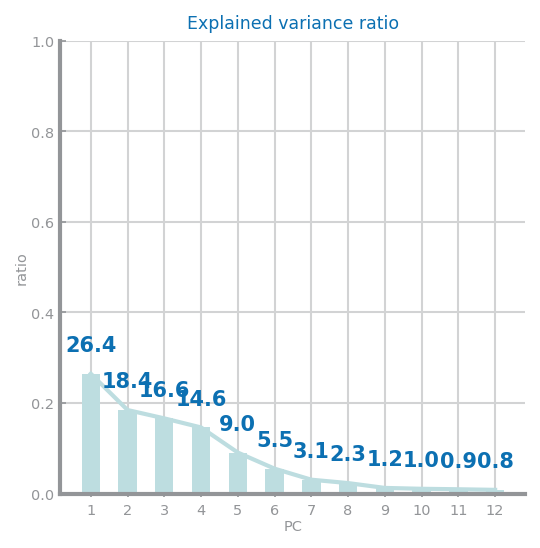

          PC1       PC2       PC3       PC4       PC5       PC6
0   -0.429551  0.447657  0.720037  0.797508 -0.734670 -0.078705
1   -0.640607  0.034629 -0.057498  0.302961 -0.683699 -0.035669
2   -1.216614  0.088836 -0.087256  0.705889  0.037275  0.030338
3   -0.358324  0.743720 -0.664005  0.666330 -0.626548 -0.176655
4    0.642281  0.088219 -0.750425  1.006802 -0.008999  0.058523
..        ...       ...       ...       ...       ...       ...
264 -0.638030 -0.291407  0.446310  1.685351  0.036660 -1.025443
265  0.009975 -0.087972 -0.037161 -0.120089  0.064480 -0.828684
266  0.400512 -0.744024 -0.226040  0.525284  0.089282 -0.901152
267 -1.214986 -0.061741 -0.154667  0.555679  0.120526 -0.991459
268 -1.200142 -0.054055 -0.153960  0.565517  0.143298 -0.979206

[269 rows x 6 columns]


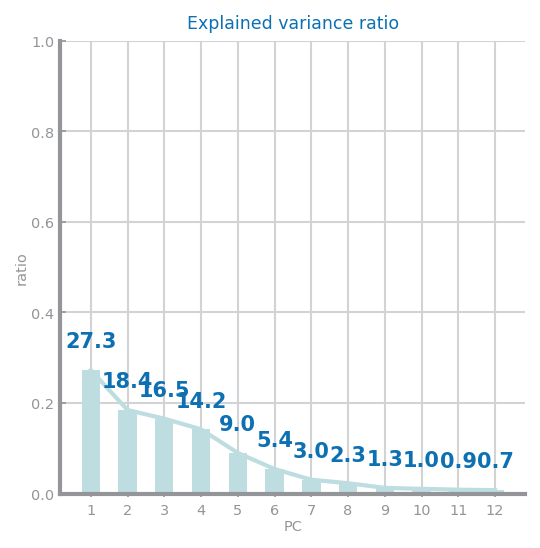

          PC1       PC2       PC3       PC4       PC5       PC6
0   -0.443530  0.281283  0.944789  0.566601 -0.756842  0.087068
1   -0.647566  0.020783  0.023679  0.279997 -0.698445  0.058944
2   -1.214768  0.086355  0.066740  0.719155  0.000139 -0.016584
3   -0.345192  0.799449 -0.363920  0.743129 -0.701723  0.218197
4    0.665482  0.182657 -0.472843  1.132768 -0.074759 -0.022604
..        ...       ...       ...       ...       ...       ...
264 -0.657554 -0.429519  0.742746  1.515210 -0.037915  1.073438
265 -0.017684 -0.096578 -0.080659 -0.137805  0.059307  0.843491
266  0.382957 -0.725777 -0.207119  0.529538  0.070746  0.951693
267 -1.233324 -0.069659 -0.059227  0.568379  0.065560  1.021591
268 -1.218363 -0.061034 -0.052284  0.574695  0.090500  1.011589

[269 rows x 6 columns]


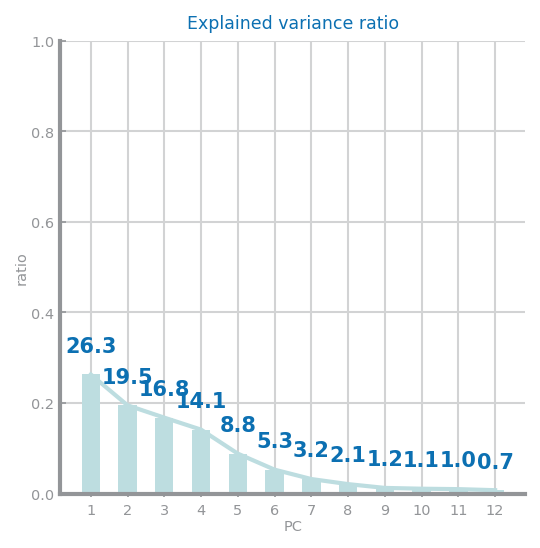

          PC1       PC2       PC3       PC4       PC5       PC6
0   -0.494608  0.617426  0.356177  0.885755 -0.677972  0.084469
1   -0.632984  0.014111 -0.159922  0.279846 -0.669297  0.009594
2   -1.246415  0.064395 -0.338719  0.557125  0.053206 -0.003840
3   -0.363006  0.607550 -0.953072  0.362606 -0.625445  0.197437
4   -0.842401  1.218029 -0.553837  1.238297  0.086319  0.209558
..        ...       ...       ...       ...       ...       ...
264 -0.739370 -0.138603 -0.010461  1.643869  0.088634  1.107317
265  0.012697 -0.127721  0.024354 -0.177166  0.042729  0.809977
266  0.397838 -0.746281 -0.202174  0.502738  0.111874  0.933015
267 -1.238642 -0.136238 -0.307494  0.363427  0.081408  1.011969
268 -1.225554 -0.126077 -0.312440  0.372115  0.110054  1.010894

[269 rows x 6 columns]


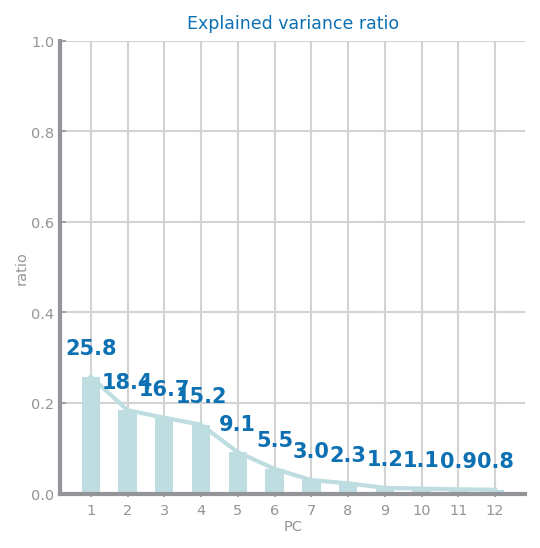

          PC1       PC2       PC3       PC4       PC5       PC6
0   -0.425873  0.542068  0.458849  0.866255 -0.817841  0.015295
1   -0.634081  0.013437 -0.113169  0.258446 -0.720672  0.034574
2   -1.239732  0.124210 -0.237128  0.632155 -0.022300  0.058216
3   -0.375235  0.680488 -0.862231  0.385812 -0.695300 -0.106188
4    0.607080  0.095424 -0.997454  0.787007 -0.003216  0.095984
..        ...       ...       ...       ...       ...       ...
265 -0.639650  0.050076 -1.264882  1.310216 -0.024387 -0.898147
266 -0.680035 -0.112026  0.056544  1.772984 -0.119308 -0.981502
267 -0.009563 -0.102502  0.005202 -0.099885 -0.015233 -0.829727
268 -1.246395 -0.043510 -0.251125  0.513971 -0.020226 -0.977204
269 -1.234323 -0.027207 -0.253175  0.523457 -0.002284 -0.960646

[270 rows x 6 columns]


In [51]:
old_datasets = {'train': train_data, 'test': test_data}
new_datasets = {'train': (), 'test': ()}

for spli in range(len(old_datasets['train'])):
    dataset = old_datasets['train'][spli]
    target_data = dataset.pop('DEATH_EVENT').reset_index(drop=True)
    data = dataset.copy(deep = True)

    from sklearn.decomposition import PCA

    mean = (data.mean(axis=0)).tolist()
    centered_data = data - mean
    cov_mtx = centered_data.cov()
    eigvals, eigvecs = np.linalg.eig(cov_mtx)

    pca = PCA()
    pca.fit(centered_data)
    PC = pca.components_
    var = pca.explained_variance_

    # PLOT EXPLAINED VARIANCE RATIO
    fig = plt.figure(figsize=(4, 4))
    plt.title('Explained variance ratio')
    plt.xlabel('PC')
    plt.ylabel('ratio')
    x_values = [str(i) for i in range(1, len(pca.components_) + 1)]
    bwidth = 0.5
    ax = plt.gca()
    ax.set_xticklabels(x_values)
    ax.set_ylim(0.0, 1.0)
    ax.bar(x_values, pca.explained_variance_ratio_, width=bwidth)
    ax.plot(pca.explained_variance_ratio_)
    for i, v in enumerate(pca.explained_variance_ratio_):
        ax.text(i, v+0.05, f'{v*100:.1f}', ha='center', fontweight='bold')
    plt.show()
    
    pcs = ['PC' + str(i) for i in range(1, 6 + 1)]
    
    # Transform train data
    transf = pca.transform(data)
    data = pd.DataFrame(transf[:,:6], columns=pcs)
    print(data)
    data = data.join(target_data, how='right')

    new_datasets['train'] += (data,)
    
    test_dataset = old_datasets['test'][spli]
    test_target_data = test_dataset.pop('DEATH_EVENT').reset_index(drop=True)
    test_data = test_dataset.copy(deep = True)
    
    # Transform test data
    test_transf = pca.transform(old_datasets['test'][spli])
    test_data = pd.DataFrame(test_transf[:,:6], columns=pcs)
    test_data = test_data.join(test_target_data, how='right')
    
    new_datasets['test'] += (test_data,)    

In [52]:
for spli in range(len(new_datasets['test'])):
    new_datasets['test'][spli].to_csv('data/prepared_fe_test/%d.csv' % spli, sep=';', index=False)
    new_datasets['train'][spli].to_csv('data/prepared_mm_fe/%d.csv' % spli, sep=';', index=False)

         PC1       PC2       PC3       PC4       PC5       PC6  DEATH_EVENT
0   0.634990  0.217141 -0.653915  1.041791  0.036550 -0.060591         True
1   0.385672  1.095286  0.392735  0.713832 -0.050868 -0.204499        False
2   0.804991  0.529642  0.202602  1.392710 -0.074670 -0.222081         True
3  -0.068118 -0.310867  0.552160  1.294942 -0.817916 -0.338433         True
4  -0.818993 -0.572692 -0.232890  1.341482 -0.016689 -0.164202        False
5  -1.233887 -0.006130 -0.042744  0.657624  0.008233 -0.127139         True
6  -0.212561 -0.567801 -0.299296  0.956273 -0.685831 -0.259114        False
7  -0.436033  0.490626  0.151667  2.077822 -0.090864 -0.335550        False
8   0.792170  0.498725  0.185351  1.384916 -0.081750 -0.409427         True
9   0.023905 -0.020531 -0.016712 -0.057300  0.066572 -0.288335        False
10 -1.236861  0.013074 -0.041530  0.645118 -0.001613 -0.126544        False
11 -0.628041  0.003794 -0.115632  0.258586 -0.672303 -0.215935         True
12 -0.010486

### Summary

---

***Are all variables in the same scale? If not, how does scaling impact the results?***

No, the numeric variables have different scales. After applying scaling, the results (with Naive Bayes algorithm) were similar, but slightly worse. After removing the outliers, the results were slightly better.

***Is the dataset unbalanced? If yes, what is the best balancing technique to apply?***

Yes, the dataset is unbalanced. To balance it we used SMOTE, an oversampling technique.